In [1867]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
all_files = glob.glob("../roll_data/*-swing-on-ball.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files),
               ignore_index=True)

seasons = [11, 12, 13]
# seasons = [11, 12, 13]
# seasons = [13]
# seasons = [14]
df = df[df['season'].isin(seasons)]
len(df)

252462

In [1868]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [1875]:
dfc = df.copy()
# dfc = dfc[dfc["is_strike"] == True]
# dfc = dfc[dfc["stadium_id"].isna()]
dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

for exclude_mod in ["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH", "ON_FIRE", "SPICY"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]
# dfc = dfc[(dfc["pitcher_multiplier"] == 1) & (dfc["batter_multiplier"] == 1)]
# dfc_bad = dfc[dfc["combined_batting"] < 0].copy()
# dfc = dfc[dfc["combined_batting"] >= 0]
len(dfc)

192693

In [1876]:
dfc.loc[dfc["passed"], "roll"].max()

0.9492693003761858

In [1877]:
dfc.loc[~dfc["passed"], "roll"].min()

0.0001587301311227

In [1878]:

dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])# * df["pitcher_multiplier"]
dfc["mox"] = dfc["batter_moxie"] * (1+0.2*dfc["batter_vibes"])
dfc["path"] = dfc["batter_patheticism"]# * (1+0.2*dfc["batter_vibes"])

dfc["ruth_scaled"] = dfc["ruth"] * dfc["pitcher_multiplier"]
dfc["mox_scaled"] = dfc["mox"] * dfc["batter_multiplier"]
dfc["path_scaled"] = dfc["path"] / dfc["batter_multiplier"]

dfc["roll_pow"] = (dfc["roll"] - 0.05)**(1/1.4)

dfc["combined"] = dfc["ruth_scaled"]*12 - 5*dfc["mox_scaled"] + 5*dfc["path_scaled"] + 4*dfc["visc_center"]
dfc["combined_pow"] = dfc["combined"] ** 1.4
dfc["combined_log"] = np.log(dfc["combined"])# ** 1.4
# dfc = dfc[~dfc["combined_pow"].isna()]
# dfc = dfc[~dfc["roll_pow"].isna()]


In [1879]:
dfc["combined"].describe()

count    192693.000000
mean          6.390098
std           4.256920
min         -10.925162
25%           3.375179
50%           6.315239
75%           9.287279
max          24.035423
Name: combined, dtype: float64

KeyError: 'combined_batting'

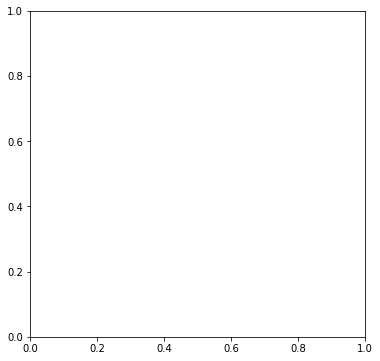

In [1874]:
x_val = "combined_batting"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Swing",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Swing",
    marker=CARETLEFTBASE,
)


ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Swing")
# ax.set_ylim(0.6, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

In [1880]:
X = dfc[
    [
        "roll",
        "roll_pow",
        "passed",
        "combined",

        # "ruth_scaled",
        # "mox_scaled",
        # "path_scaled",

        # "fwd_center",
        # "fort_center",
        # "visc_center",
        # "elong_center",
    ]
].copy()
# X = X[X['roll_pow'] < 0.9]
# X = X[X['roll_pow'] > 0.2]
# X["roll"] = (X["roll"] - 0.05)**(1/1.4)
X = X[~X["roll_pow"].isna()]
X = X[X["roll"] < 0.95]
X = X[X["roll"] > 0.2]
X = X.drop("roll", axis=1)

# pin_intercept = None
pin_intercept = 0
pins = [
    # (0.05333333, "combined")
]
for val, var in pins:
    X["roll_pow"] -= X[var] * val
    X = X.drop(var, axis=1)

y = X["passed"]
X = X.drop(["passed"], axis=1)

In [1881]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=500000, C=1000000000000, tol=1e-15,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
# print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[118364     31]
 [    14  26066]]
0.9996885274268905


In [1882]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] not in ["roll", "roll_pow"]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]


intercept: 0
(0.053372579340285664, 'combined')


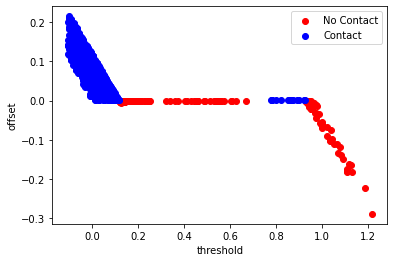

In [1883]:
dfc["offset"] = dfc["roll_pow"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [1884]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        "roll",
        "roll_pow",
        "threshold",
        "ruth",
        "combined",
        # "combined_batting",
        # "combined_batting_0.5",
        # "combined_batting_1.25",
        # "combined_batting_0.25",
        "pitcher_multiplier",
        "batter_multiplier",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "batter_vibes"
        # "fielder_roll",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)

1064


,passed,offset,roll,roll_pow,threshold,ruth,combined,pitcher_multiplier,batter_multiplier,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count
78391,True,0.214256,0.097823,0.113994,-0.100262,0.567456,-1.878528,1.0,1.0,Jaxon Buckley,Bontgomery Mullock,FIRE_EATER,FRIEND_OF_CROWS;WILD,AFFINITY_FOR_CROWS,LOVE;EXTRA_STRIKE,12,20,f30b7c9f-2d72-4fb2-95b3-e269a926e3fe,22
129162,True,0.210492,0.095868,0.110646,-0.099846,0.313024,-1.870730,1.0,1.0,Avila Guzman,Wanda Schenn,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,BOTTOM_DWELLER,12,66,0e8a0d5f-c1c0-4cab-8502-e931f8e0d1ae,81
78614,True,0.208964,0.094744,0.108702,-0.100262,0.567456,-1.878528,1.0,1.0,Jaxon Buckley,Bontgomery Mullock,FIRE_EATER,FRIEND_OF_CROWS;WILD,AFFINITY_FOR_CROWS,LOVE;EXTRA_STRIKE,12,20,f30b7c9f-2d72-4fb2-95b3-e269a926e3fe,88
48857,True,0.206290,0.097089,0.112741,-0.093549,0.117552,-1.752746,1.0,1.0,Ortiz Lopez,Cory Twelve,FIRE_EATER,NaN,LOVE;PARTY_TIME,O_NO,11,89,39b5d815-9a79-44e3-b754-b3764edb02d9,308
174326,True,0.204284,0.095619,0.110217,-0.094067,0.314402,-1.762464,1.0,1.0,Knight Triumphant,Alaynabella Hollywood,SIPHON;PERK,NaN,LOVE,NaN,13,12,f4219377-d57b-4d6c-afe6-99725671c271,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128874,False,-0.179518,0.953886,0.930363,1.109881,1.460821,20.794969,1.0,1.0,Combs Estes,Burke Gonzales,SIPHON,ALTERNATE,EXTRA_STRIKE,NaN,12,65,e78e7dec-516a-4f6d-9d52-32bdee40ebf2,349
187114,False,-0.181578,0.976615,0.947015,1.128593,1.383681,21.145561,1.0,1.0,Stephens Lightner,Burke Gonzales,NaN,ALTERNATE,EARLBIRDS,NaN,13,30,43972cde-c97b-4e33-8a7d-d01e5463a23c,33
128878,False,-0.182341,0.950048,0.927540,1.109881,1.460821,20.794969,1.0,1.0,Combs Estes,Burke Gonzales,SIPHON,ALTERNATE,EXTRA_STRIKE,NaN,12,65,e78e7dec-516a-4f6d-9d52-32bdee40ebf2,351
280,False,-0.223717,0.996718,0.961645,1.185362,1.438671,22.209191,1.0,1.0,Stew Briggs,PolkaDot Patterson,REPEATING,SQUIDDISH,NaN,NaN,11,30,49676eae-61f9-4b70-9b8a-695424a219b1,114


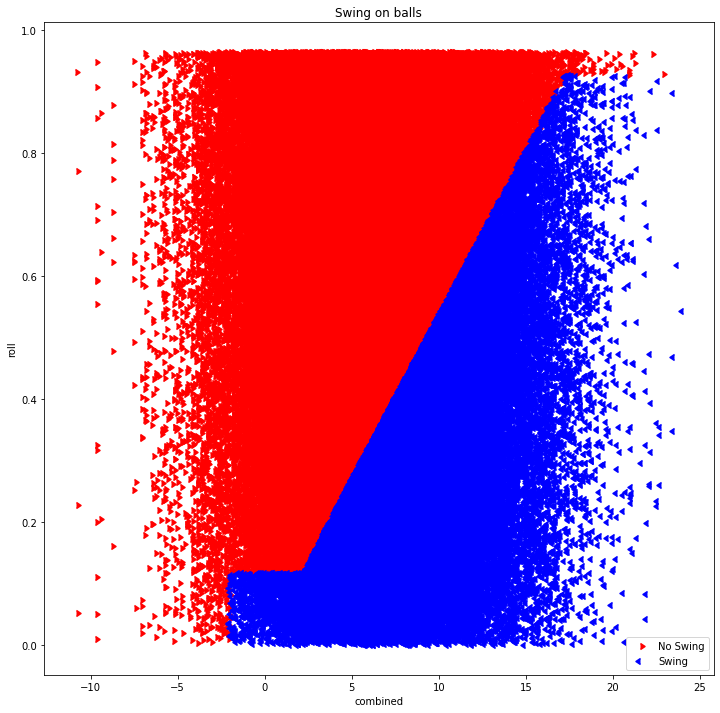

In [1889]:
x_val = "combined"
y_val = "roll_pow"
fig, ax = plt.subplots(1, figsize=(12, 12))

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Swing",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Swing",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Swing on balls")

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend(loc="lower right")

In [1891]:
dfc[dfc["passed"]]["combined"].min()

-1.9957643428012328